
# Metodi di Ricerca in AI — Notebook

Algoritmi di ricerca:

- **Ricerca non informata (blind)**: Breadth‑First Search (BFS), Depth‑First Search (DFS), Iterative deepening search (IDS), Bidirection Search, Uniform Cost Search (UCS)
- **Ricerca informata (heuristic)**: **Greedy Best‑First**, **A\*** (con `f(n)=g(n)+h(n)`)

Obiettivi:
1. Implementazioni **pulite** e riutilizzabili degli algoritmi.
2. Esempi su una **griglia** con ostacoli (con visualizzazioni).
3. Confronto di **costo**, **nodi espansi** e **dimensione massima della frontiera**.



## Setup e utilità
Funzioni base per: code, grafi a griglia, ricostruzione del cammino, metriche.


In [14]:

from collections import deque
import heapq
from dataclasses import dataclass
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple, Set

import matplotlib.pyplot as plt

Coord = Tuple[int, int]  # (r, c)

@dataclass
class SearchResult:
    path: List[Coord]
    cost: float
    expanded: int
    max_frontier: int
    found: bool
    name: str

def reconstruct_path(came_from: Dict[Coord, Optional[Coord]], start: Coord, goal: Coord) -> List[Coord]:
    if goal not in came_from:
        return []
    cur = goal
    out = [cur]
    while cur != start:
        cur = came_from[cur]
        if cur is None:
            return []
        out.append(cur)
    out.reverse()
    return out

class Grid:
    def __init__(self, rows: int, cols: int, walls: Set[Coord] | None = None, cost_fn: Optional[Callable[[Coord], float]] = None):
        self.rows, self.cols = rows, cols
        self.walls = walls or set()
        self.cost_fn = cost_fn or (lambda _: 1.0)

    def in_bounds(self, s: Coord) -> bool:
        r, c = s
        return 0 <= r < self.rows and 0 <= c < self.cols

    def passable(self, s: Coord) -> bool:
        return s not in self.walls

    def neighbors(self, s: Coord) -> Iterable[Coord]:
        r, c = s
        # 4-neighbors (N,E,S,W)
        for dr, dc in [(-1,0),(0,1),(1,0),(0,-1)]:
            t = (r+dr, c+dc)
            if self.in_bounds(t) and self.passable(t):
                yield t

    def step_cost(self, s: Coord, t: Coord) -> float:
        # costo associato allo stato di arrivo t (cell-based cost)
        return float(self.cost_fn(t))

def manhattan(a: Coord, b: Coord) -> float:
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def plot_grid(grid: Grid, start: Coord, goal: Coord, path: List[Coord] | None = None, title: str = ""):
    # Singola figura per chiamata (no subplots)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim(-0.5, grid.cols-0.5)
    ax.set_ylim(-0.5, grid.rows-0.5)
    ax.set_xticks(range(grid.cols))
    ax.set_yticks(range(grid.rows))
    ax.grid(True)

    # muri
    for (r,c) in grid.walls:
        ax.add_patch(plt.Rectangle((c-0.5, r-0.5), 1, 1, alpha=0.5))

    # path
    if path:
        xs = [c for r,c in path]
        ys = [r for r,c in path]
        ax.plot(xs, ys, linewidth=2, marker="o")

    # start/goal
    ax.text(start[1], start[0], "S", ha="center", va="center", fontsize=12)
    ax.text(goal[1], goal[0], "G", ha="center", va="center", fontsize=12)
    ax.set_title(title)
    plt.show()

def _dls(grid: Grid, start: Coord, goal: Coord, depth_limit: int):
    """
    Depth-Limited Search (versione iterativa, stile tree-search).
    Restituisce: (found, came_from, expanded, max_frontier)
    """
    # stack di tuple: (stato, profondità, padre)
    stack = [(start, 0, None)]
    came_from: Dict[Coord, Optional[Coord]] = {}
    expanded = 0
    max_frontier = 1

    # Per evitare cicli nel percorso corrente, tracciamo i nodi sul path in stack.
    # Usiamo anche un contatore di ingressi/uscite per gestire il "path set" in modo iterativo.
    onpath_count: Dict[Coord, int] = {}

    while stack:
        max_frontier = max(max_frontier, len(stack))
        s, d, parent = stack.pop()

        # aggiorna path set
        onpath_count[s] = onpath_count.get(s, 0) + 1
        if parent is not None and s not in came_from:
            came_from[s] = parent
        elif s == start:
            came_from.setdefault(s, None)

        expanded += 1
        if s == goal:
            return True, came_from, expanded, max_frontier

        if d < depth_limit:
            # espandi successori (ordine LIFO per DFS; opzionale invertirli)
            # per coerenza con neighbors() che produce N,E,S,W, possiamo pushare in ordine inverso
            nbrs = list(grid.neighbors(s))
            for t in reversed(nbrs):
                # evita cicli sul percorso corrente
                if onpath_count.get(t, 0) == 0:
                    stack.append((t, d + 1, s))

        # uscita dal nodo: decrementa path set
        onpath_count[s] -= 1
        if onpath_count[s] == 0:
            del onpath_count[s]

    return False, came_from, expanded, max_frontier



## Algoritmi di ricerca non informata
Implementazioni essenziali con conteggi di **nodi espansi** e **massima frontiera**.


In [15]:
#
# Breadth-first search algorithm (uniform cost)
#
# Always expand the less deep node of the tree; so search on the graph in an horizontal way.
# The main problem is the memory:
#   if d is the deep of the graph
#   if r is the ramification of the graph
#   we need to exapand r^d nodes
# This strategy guarantee completion but not efficiency on mono-processor systems architecture.


def bfs(grid: Grid, start: Coord, goal: Coord) -> SearchResult:
    frontier = deque([start])
    came_from: Dict[Coord, Optional[Coord]] = {start: None}
    expanded = 0
    max_frontier = 1
    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        s = frontier.popleft()
        expanded += 1
        if s == goal:
            path = reconstruct_path(came_from, start, goal)
            return SearchResult(path, cost=len(path)-1 if path else float('inf'), expanded=expanded, max_frontier=max_frontier, found=bool(path), name="BFS")
        for t in grid.neighbors(s):
            if t not in came_from:
                came_from[t] = s
                frontier.append(t)
    return SearchResult([], float('inf'), expanded, max_frontier, False, "BFS")


In [16]:
#
# Depth-first search algorithm
#
# Expand first the deepest node.
# Memory usage is lower compared to the breath-first algorithm.
#   if d is the deep of the graph
#   if r is the ramification of the graph
#   maximal number of nodes to expand will be r^d
# The strategy doesn't guarantee completion due fails in infinite-depth spaces, spaces with loop; but is complete for finite spaces.
# Faste than breadth-first is the solutions are dense.
# Not optimal algorithm.

def dfs(grid: Grid, start: Coord, goal: Coord, depth_limit: Optional[int]=None) -> SearchResult:
    stack = [start]
    came_from: Dict[Coord, Optional[Coord]] = {start: None}
    expanded = 0
    max_frontier = 1
    depth: Dict[Coord, int] = {start: 0}
    while stack:
        max_frontier = max(max_frontier, len(stack))
        s = stack.pop()
        expanded += 1
        if s == goal:
            path = reconstruct_path(came_from, start, goal)
            # costo come numero di passi
            return SearchResult(path, cost=len(path)-1 if path else float('inf'), expanded=expanded, max_frontier=max_frontier, found=bool(path), name="DFS")
        if depth_limit is not None and depth[s] >= depth_limit:
            continue
        for t in grid.neighbors(s):
            if t not in came_from:
                came_from[t] = s
                depth[t] = depth[s] + 1
                stack.append(t)
    return SearchResult([], float('inf'), expanded, max_frontier, False, "DFS")


In [17]:
#
# Iterative deepening search (IDS)
#
# Use deep limit bounder by trying every possibile deep value (0, 1, 2, ...).
# Emulate the breadth-first as macrosteps but appling the depth-first until the limit bounder and incrementing it each time are discovered all the nodes.
# Is one of the most used in case of huge graph.

def ids(grid: Grid, start: Coord, goal: Coord, max_depth_limit: Optional[int] = None) -> SearchResult:
    """
    Iterative Deepening Search (IDS): ripete DLS con profondità 0,1,2,...
    - Completo su grafi finiti.
    - Ottimo in numero di passi se tutti i costi di passo sono uguali.
    - Memoria O(b*d).
    """
    # se possibile, un limite "ragionevole": numero celle raggiungibili
    if max_depth_limit is None:
        # upper bound deterministico: righe*colonne - 1 (senza considerare muri)
        max_depth_limit = grid.rows * grid.cols - 1

    total_expanded = 0
    overall_max_frontier = 0
    best_came_from: Dict[Coord, Optional[Coord]] = {}

    for depth_limit in range(max_depth_limit + 1):
        found, came_from, expanded, max_frontier = _dls(grid, start, goal, depth_limit)
        total_expanded += expanded
        overall_max_frontier = max(overall_max_frontier, max_frontier)
        best_came_from = came_from

        if found:
            path = reconstruct_path(best_came_from, start, goal)
            # costo come numero di passi (uniform-cost in passi)
            return SearchResult(
                path=path,
                cost=len(path) - 1 if path else float("inf"),
                expanded=total_expanded,
                max_frontier=overall_max_frontier,
                found=True,
                name="IDS",
            )

    # non trovato entro il limite
    return SearchResult(
        path=[],
        cost=float("inf"),
        expanded=total_expanded,
        max_frontier=overall_max_frontier,
        found=False,
        name="IDS",
    )


In [18]:
#
# Bidirectional Search
#
# Mixed of backward and forward methods. 
# You need to know the position of the goal node.
# One method start from the start and the other from the goal.
# The memory is splitted in two parts: backward chaining and forward chaining.
# Simultanously apply the F-rules and B-rules to the memory parts until the chains are equals.

from collections import deque
from typing import Optional, Dict, Tuple, List

def bidirectional_bfs(grid: Grid, start: Coord, goal: Coord) -> SearchResult:
    """
    Ricerca bidirezionale non informata (BFS-BFS).
    - Espande in parallelo due BFS: una da start e una da goal.
    - Quando le frontiere si incontrano, ricostruisce il cammino minimo in numero di passi.
    - Completa su grafi finiti e ottima (in passi) con costi unitari.

    Restituisce: SearchResult(path, cost=#passi, expanded=#nodi_espansi, max_frontier, found, "BiBFS")
    """
    # casi banali
    if start == goal:
        return SearchResult(path=[start], cost=0.0, expanded=0, max_frontier=1, found=True, name="BiBFS")
    if not grid.passable(start) or not grid.passable(goal):
        return SearchResult(path=[], cost=float("inf"), expanded=0, max_frontier=0, found=False, name="BiBFS")

    frontier_fwd = deque([start])
    frontier_bwd = deque([goal])

    came_from_fwd: Dict[Coord, Optional[Coord]] = {start: None}
    came_from_bwd: Dict[Coord, Optional[Coord]] = {goal: None}

    expanded_total = 0
    max_frontier = len(frontier_fwd) + len(frontier_bwd)

    def _expand(frontier: deque, came_from_this: Dict[Coord, Optional[Coord]], came_from_other: Dict[Coord, Optional[Coord]]) -> Tuple[Optional[Coord], int]:
        """Espande un nodo dalla frontiera data. Ritorna (meeting_node|None, expanded_count=1)."""
        if not frontier:
            return None, 0
        s = frontier.popleft()
        expanded = 1
        for t in grid.neighbors(s):
            if t not in came_from_this:
                came_from_this[t] = s
                # incontro delle due ricerche
                if t in came_from_other:
                    return t, expanded
                frontier.append(t)
        return None, expanded

    # ciclo: espande ogni volta la frontiera più piccola per bilanciare
    while frontier_fwd and frontier_bwd:
        max_frontier = max(max_frontier, len(frontier_fwd) + len(frontier_bwd))

        if len(frontier_fwd) <= len(frontier_bwd):
            meet, exp = _expand(frontier_fwd, came_from_fwd, came_from_bwd)
        else:
            meet, exp = _expand(frontier_bwd, came_from_bwd, came_from_fwd)

        expanded_total += exp

        if meet is not None:
            # ricostruzione: start -> meet (via forward) + meet -> goal (via backward)
            path_start_to_meet = reconstruct_path(came_from_fwd, start, meet)      # [start,...,meet]
            path_goal_to_meet  = reconstruct_path(came_from_bwd, goal, meet)       # [goal,...,meet]
            if not path_start_to_meet or not path_goal_to_meet:
                # fallback improbabile
                return SearchResult([], float("inf"), expanded_total, max_frontier, False, "BiBFS")

            tail_meet_to_goal = list(reversed(path_goal_to_meet))                   # [meet,...,goal]
            full_path = path_start_to_meet + tail_meet_to_goal[1:]                 # evita 'meet' doppio

            return SearchResult(
                path=full_path,
                cost=len(full_path) - 1,
                expanded=expanded_total,
                max_frontier=max_frontier,
                found=True,
                name="BiBFS",
            )

    # non connessi
    return SearchResult([], float("inf"), expanded_total, max_frontier, False, "BiBFS")


In [19]:

def ucs(grid: Grid, start: Coord, goal: Coord) -> SearchResult:
    frontier: List[Tuple[float, Coord]] = [(0.0, start)]
    came_from: Dict[Coord, Optional[Coord]] = {start: None}
    g: Dict[Coord, float] = {start: 0.0}
    expanded = 0
    max_frontier = 1
    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        cost_s, s = heapq.heappop(frontier)
        if s == goal:
            path = reconstruct_path(came_from, start, goal)
            return SearchResult(path, cost=g[s], expanded=expanded, max_frontier=max_frontier, found=True, name="UCS")
        expanded += 1
        for t in grid.neighbors(s):
            new_cost = g[s] + grid.step_cost(s, t)
            if t not in g or new_cost < g[t]:
                g[t] = new_cost
                came_from[t] = s
                heapq.heappush(frontier, (new_cost, t))
    return SearchResult([], float('inf'), expanded, max_frontier, False, "UCS")



## Algoritmi di ricerca informata
Implementazioni essenziali con conteggi di **nodi espansi** e **massima frontiera**.


In [20]:

def greedy_best_first(grid: Grid, start: Coord, goal: Coord, h: Callable[[Coord], float]) -> SearchResult:
    frontier: List[Tuple[float, Coord]] = [(h(start), start)]
    came_from: Dict[Coord, Optional[Coord]] = {start: None}
    visited: Set[Coord] = set()
    expanded = 0
    max_frontier = 1
    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        _, s = heapq.heappop(frontier)
        if s in visited:
            continue
        visited.add(s)
        expanded += 1
        if s == goal:
            path = reconstruct_path(came_from, start, goal)
            # costo in passi (non tiene conto di pesi se presenti!)
            return SearchResult(path, cost=len(path)-1 if path else float('inf'), expanded=expanded, max_frontier=max_frontier, found=bool(path), name="Greedy")
        for t in grid.neighbors(s):
            if t not in visited:
                came_from.setdefault(t, s if t not in came_from else came_from[t])
                heapq.heappush(frontier, (h(t), t))
    return SearchResult([], float('inf'), expanded, max_frontier, False, "Greedy")


In [21]:

def astar(grid: Grid, start: Coord, goal: Coord, h: Callable[[Coord], float]) -> SearchResult:
    frontier: List[Tuple[float, Coord]] = [(0.0, start)]
    came_from: Dict[Coord, Optional[Coord]] = {start: None}
    g: Dict[Coord, float] = {start: 0.0}
    expanded = 0
    max_frontier = 1

    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        f_s, s = heapq.heappop(frontier)
        if s == goal:
            path = reconstruct_path(came_from, start, goal)
            return SearchResult(path, cost=g[s], expanded=expanded, max_frontier=max_frontier, found=True, name="A*")
        expanded += 1
        for t in grid.neighbors(s):
            new_g = g[s] + grid.step_cost(s, t)
            if t not in g or new_g < g[t]:
                g[t] = new_g
                came_from[t] = s
                f_t = new_g + h(t)
                heapq.heappush(frontier, (f_t, t))
    return SearchResult([], float('inf'), expanded, max_frontier, False, "A*")



## Esempio 1 — Griglia 10×10 con ostacoli (costi uniformi)
Confrontiamo i 5 algoritmi su un percorso con **costi unitari** e **Manhattan** come euristica.


BFS    | found=True | cost=18.0 | expanded=86 | max_frontier=9
DFS    | found=True | cost=18.0 | expanded=19 | max_frontier=16
UCS    | found=True | cost=18.0 | expanded=85 | max_frontier=9
Greedy | found=True | cost=18.0 | expanded=19 | max_frontier=17
A*     | found=True | cost=18.0 | expanded=85 | max_frontier=10


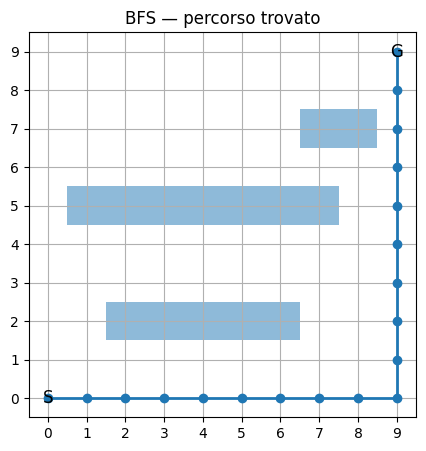

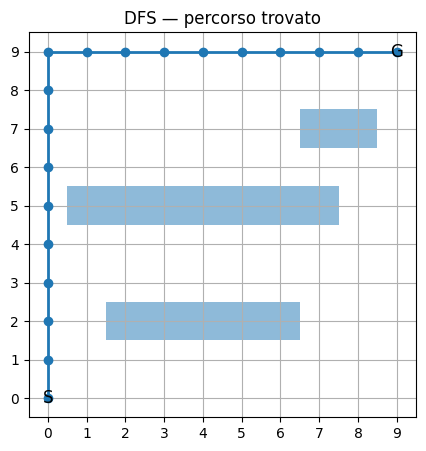

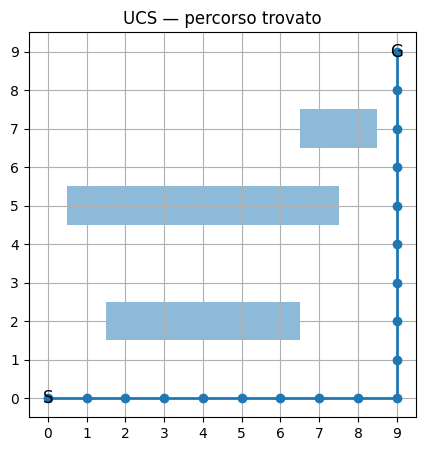

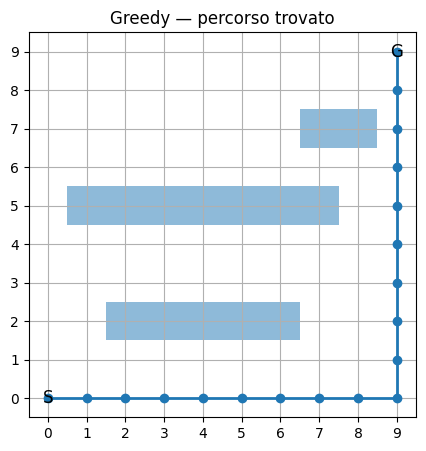

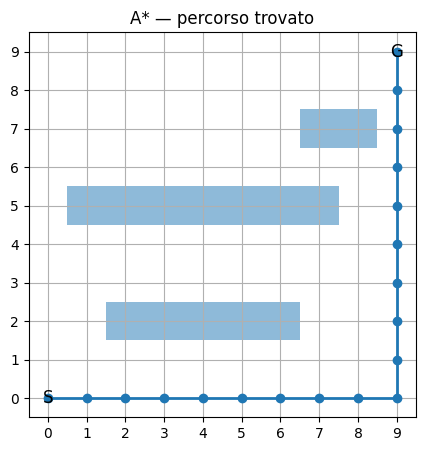

In [22]:

# Definizione griglia
rows, cols = 10, 10
walls = {
    (2,2),(2,3),(2,4),(2,5),(2,6),
    (5,1),(5,2),(5,3),(5,4),(5,5),(5,6),(5,7),
    (7,7),(7,8)
}
grid = Grid(rows, cols, walls=walls)
start, goal = (0,0), (9,9)
h = lambda s: manhattan(s, goal)

# Esecuzione
res_bfs = bfs(grid, start, goal)
res_dfs = dfs(grid, start, goal)
res_ucs = ucs(grid, start, goal)
res_greedy = greedy_best_first(grid, start, goal, h)
res_astar = astar(grid, start, goal, h)

results = [res_bfs, res_dfs, res_ucs, res_greedy, res_astar]

for r in results:
    print(f"{r.name:6s} | found={r.found} | cost={r.cost:.1f} | expanded={r.expanded} | max_frontier={r.max_frontier}")

# Visualizzazioni (una figura per algoritmo)
plot_grid(grid, start, goal, res_bfs.path, title="BFS — percorso trovato")
plot_grid(grid, start, goal, res_dfs.path, title="DFS — percorso trovato")
plot_grid(grid, start, goal, res_ucs.path, title="UCS — percorso trovato")
plot_grid(grid, start, goal, res_greedy.path, title="Greedy — percorso trovato")
plot_grid(grid, start, goal, res_astar.path, title="A* — percorso trovato")



## Esempio 2 — Griglia 10×10 con **costi variabili**
Aggiungiamo **costi maggiorati** su alcune celle per mostrare le differenze tra Greedy (ignora `g`) e A* / UCS.


UCS    | found=True | cost=18.0 | expanded=84 | max_frontier=12
Greedy | found=True | cost=18.0 | expanded=19 | max_frontier=17
A*     | found=True | cost=18.0 | expanded=65 | max_frontier=16


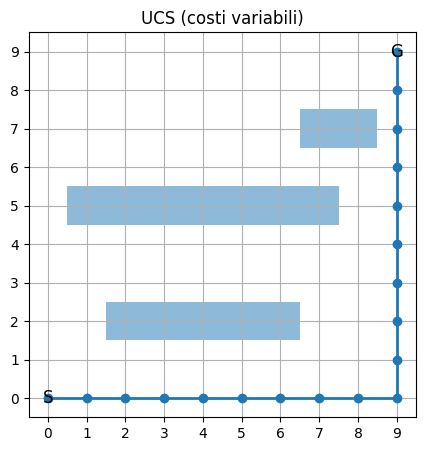

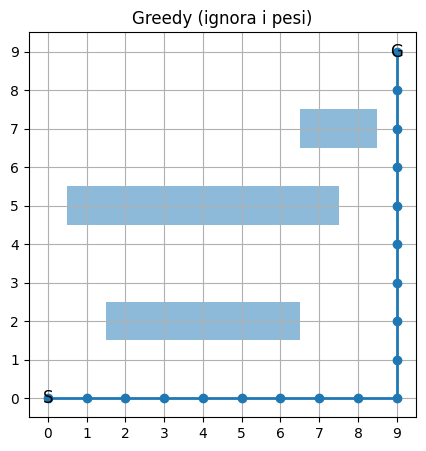

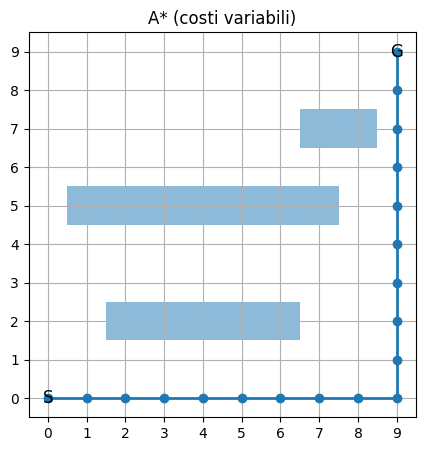

In [23]:

# Definiamo alcune 'zone costose'
penalty_cells = {(3,3),(3,4),(3,5),(4,5),(6,2),(6,3),(6,4),(7,4),(8,4)}
def cost_fn(cell: Coord) -> float:
    return 5.0 if cell in penalty_cells else 1.0

grid_w = Grid(rows, cols, walls=walls, cost_fn=cost_fn)

res_ucs_w = ucs(grid_w, start, goal)
res_greedy_w = greedy_best_first(grid_w, start, goal, h)  # ignora i pesi!
res_astar_w = astar(grid_w, start, goal, h)

for r in [res_ucs_w, res_greedy_w, res_astar_w]:
    print(f"{r.name:6s} | found={r.found} | cost={r.cost:.1f} | expanded={r.expanded} | max_frontier={r.max_frontier}")

plot_grid(grid_w, start, goal, res_ucs_w.path, title="UCS (costi variabili)")
plot_grid(grid_w, start, goal, res_greedy_w.path, title="Greedy (ignora i pesi)")
plot_grid(grid_w, start, goal, res_astar_w.path, title="A* (costi variabili)")



## Proprietà dell'euristica: ammissibilità e consistenza
- **Ammissibile**: `h(n) ≤ h*(n)` (non sovrastima il costo ottimo al goal).
- **Consistente**: `h(n) ≤ c(n,a,n') + h(n')` per ogni arco `(n,n')`.

Sulla griglia 4‑connessa, la **Manhattan** è **ammissibile e consistente** (se il costo minimo per passo è ≥ 1).
Verifichiamo empiricamente la **consistenza** su tutte le adiacenze.


In [24]:

def check_consistency(grid: Grid, goal: Coord, h: Callable[[Coord], float]) -> Tuple[bool, List[Tuple[Coord,Coord,float,float,float]]]:
    violations = []
    for r in range(grid.rows):
        for c in range(grid.cols):
            s = (r,c)
            if not grid.passable(s):
                continue
            for t in grid.neighbors(s):
                if not grid.passable(t):
                    continue
                lhs = h(s)
                rhs = grid.step_cost(s,t) + h(t)
                if lhs > rhs + 1e-9:
                    violations.append((s,t,lhs,rhs,lhs-rhs))
    return (len(violations) == 0, violations)

ok, viol = check_consistency(grid, goal, h)
print("Manhattan consistente su costi unitari:", ok, "| violazioni:", len(viol))

ok_w, viol_w = check_consistency(grid_w, goal, h)
print("Manhattan consistente su costi variabili (min step≥1):", ok_w, "| violazioni:", len(viol_w))


Manhattan consistente su costi unitari: True | violazioni: 0
Manhattan consistente su costi variabili (min step≥1): True | violazioni: 0



## Confronto sintetico
Tabella con **costo**, **nodi espansi** e **max frontiera** per ogni metodo, nei due scenari (costi uniformi e variabili).


In [25]:

import pandas as pd
from caas_jupyter_tools import display_dataframe_to_user

df_uniform = pd.DataFrame([
    {"Algoritmo": r.name, "Costo": r.cost, "Espansi": r.expanded, "Max frontiera": r.max_frontier}
    for r in [res_bfs, res_dfs, res_ucs, res_greedy, res_astar]
])

df_weighted = pd.DataFrame([
    {"Algoritmo": r.name, "Costo": r.cost, "Espansi": r.expanded, "Max frontiera": r.max_frontier}
    for r in [res_ucs_w, res_greedy_w, res_astar_w]
])

display_dataframe_to_user("Confronto — Costi Uniformi", df_uniform)
display_dataframe_to_user("Confronto — Costi Variabili", df_weighted)
df_uniform, df_weighted


## Confronto — Costi Uniformi


,Algoritmo,Costo,Espansi,Max frontiera
0,BFS,18.0,86,9
1,DFS,18.0,19,16
2,UCS,18.0,85,9
3,Greedy,18.0,19,17
4,A*,18.0,85,10


## Confronto — Costi Variabili


,Algoritmo,Costo,Espansi,Max frontiera
0,UCS,18.0,84,12
1,Greedy,18.0,19,17
2,A*,18.0,65,16


(  Algoritmo  Costo  Espansi  Max frontiera
 0       BFS   18.0       86              9
 1       DFS   18.0       19             16
 2       UCS   18.0       85              9
 3    Greedy   18.0       19             17
 4        A*   18.0       85             10,
   Algoritmo  Costo  Espansi  Max frontiera
 0       UCS   18.0       84             12
 1    Greedy   18.0       19             17
 2        A*   18.0       65             16)


## Cosa osservare
- **BFS** su costi unitari trova un cammino **ottimo** in numero di passi, ma può espandere molti nodi (memoria elevata).
- **DFS** usa poca memoria ma non è completa su grafi infiniti e può trovare soluzioni molto lontane dall’ottimo.
- **UCS** gestisce pesi arbitrari e garantisce l’**ottimalità** se i costi sono non negativi.
- **Greedy** segue l’euristica: spesso **veloce**, ma **non ottimo** (ignora `g(n)`).
- **A\*** combina il meglio di entrambi: con `h` **ammissibile e consistente** è **completo** e **ottimo**, ed espande meno di UCS.
